Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

acc:0.568, loss:1.415, training:True
acc:0.639, loss:1.112, training:True
acc:0.677, loss:0.974, training:True
acc:0.681, loss:0.960, training:False
{'accuracy': '0.592', 'loss': '1.355', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.666', 'loss': '0.911', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.717', 'loss': '0.794', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.728', 'loss': '0.754', 'epoch': 1, 'train': 'eval'}
{'accuracy': '0.755', 'loss': '0.689', 'epoch': 2, 'train': 'train'}
{'accuracy': '0.743', 'loss': '0.696', 'epoch': 2, 'train': 'eval'}


accuracy,loss,epoch,train
0.598,1.182,0,train
0.684,0.883,0,eval


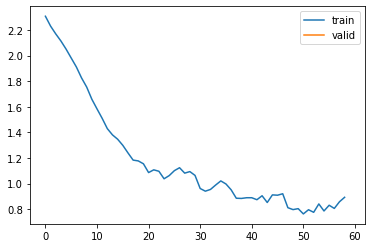

accuracy,loss,epoch,train
0.665,0.966,0,train
0.795,0.594,0,eval


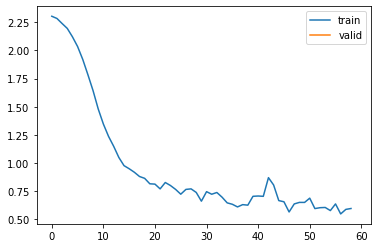

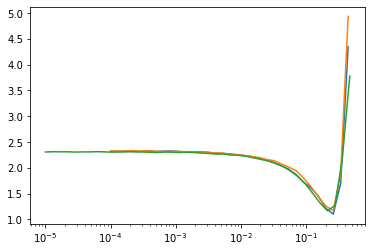

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, default_collate
from datasets import load_dataset
import matplotlib.pyplot as plt
from functools import partial
import fastcore.all as fc
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from operator import itemgetter, attrgetter
import torch.optim as optim
from functools import partial
from copy import copy
from torcheval.metrics import MulticlassAccuracy, Mean
from fastprogress import master_bar, progress_bar
from miniai.lec_9_v4 import *

In [8]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

def get_dls(train_ds, valid_ds, batch_size, **kwargs):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=batch_size*2, shuffle=False, **kwargs)
    )

def collate_dict(x):
    g = itemgetter(*x.features)
    def _f(b):
        return g(default_collate(b))
    return _f

class DataLoaders:
    def __init__(self, *ds):
        self.train,self.valid = ds[:2]
    
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), batch_size=batch_size, collate_fn=f, **kwargs))    

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

accuracy,loss,epoch,train
0.149,2.328,0,train
0.100,2.303,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

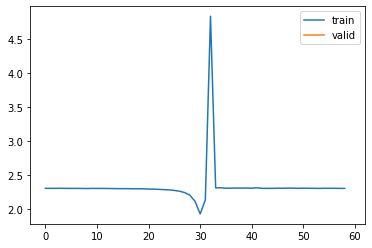

In [17]:
from torcheval.metrics import MulticlassAccuracy

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainerCB(1), metrics, ProgressCB(plot=True)]

def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, copy(dls), loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

learn = fit(nn.Sequential(*cnn_layers()))

accuracy,loss,epoch,train
0.148,2.308,0,train
0.111,2.275,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

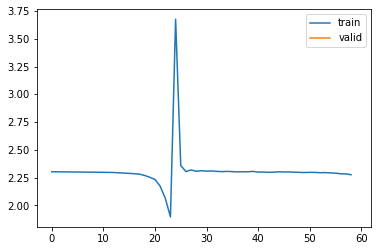

In [29]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
    
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.mean().detach())
            self.act_stds[i].append(x.std().detach())
        return x
    
    def __iter__(self):
        return iter(self.layers)
    
model = SequentialModel(*cnn_layers())
learn = fit(model)

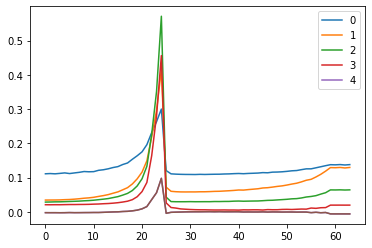

In [30]:
for l in model.act_means:
    plt.plot(l)
plt.legend(range(5))

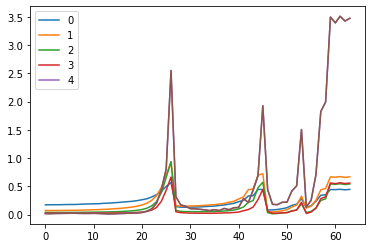

In [24]:
for l in model.act_stds:
    plt.plot(l)
plt.legend(range(5))

accuracy,loss,epoch,train
0.146,2.316,0,train
0.100,2.304,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

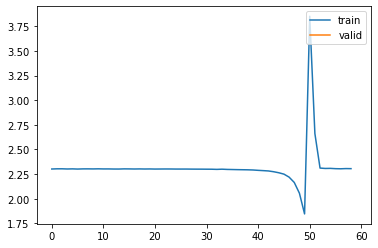

In [27]:
model = nn.Sequential(*cnn_layers())
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.mean().detach())
    act_stds[i].append(outp.std().detach())

for i,m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

fit(model)

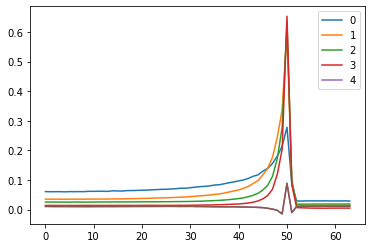

In [28]:
for o in act_means:
    plt.plot(o)
plt.legend(range(5))